In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Industries'), 90, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-04-22 to 2019-07-18 - 62


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

45


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
GDX,58,0.416407,0.763563,0.534434,30.481414,6.075660
GDXJ,58,0.411077,0.859026,0.468837,32.493094,6.657301
IHI,58,0.181167,0.388606,0.444753,13.870475,4.510425
XAR,58,0.151745,0.315812,0.454104,9.122810,2.542055
FXH,58,0.119550,0.393432,0.282685,9.051958,6.013749
XLP,58,0.110266,0.323118,0.315466,6.731026,4.021399
XLV,58,0.107788,0.354081,0.280882,7.856155,3.729859
VHT,58,0.106821,0.357413,0.275558,7.970084,4.345281
FHLC,58,0.106696,0.353478,0.278271,7.955619,4.334999


evicted XLB 0.818 0.194
evicted RYT 0.893 0.150
evicted VIS 0.829 0.234
evicted IGF 0.805 0.308
evicted EMLP 0.788 0.120
evicted VCR 0.851 0.054
evicted ARKK 0.721 0.051
evicted FXU 0.844 0.026
evicted IYF 0.802 -0.093
evicted HACK 0.882 -0.129
evicted VOX 0.495 -0.119
evicted ITB 0.687 -0.127
evicted XLP 0.678 -0.011
evicted XLU 0.433 0.220
evicted XAR 0.707 0.271
retry backlogs ['XLK', 'VGT', 'VHT', 'VPU', 'VDC', 'VFH', 'IYH', 'IYW', 'IGM', 'XLV', 'XLF', 'FNCL', 'IGV', 'FXL', 'XLY', 'VAW', 'FTEC', 'IXN', 'FHLC', 'XT', 'FDN', 'FXH', 'ITA', 'XLC', 'IYG', 'IXJ', 'GDXJ'] at 0.905/-0.51 - 0.665
evicted XT 0.846 0.158
evicted VAW 0.709 0.221
evicted XLY 0.800 0.077
evicted VDC 0.688 -0.036
evicted XLF 0.762 -0.084
evicted ITA 0.648 0.182
evicted XLC 0.534 -0.078
evicted IXJ 0.900 -0.061
evicted VPU 0.456 0.233
retry backlogs ['VGT', 'VHT', 'IYW', 'VFH', 'IYH', 'XLV', 'IGM', 'XLK', 'FTEC', 'FHLC', 'IGV', 'FXH', 'FNCL', 'FXL', 'IXN', 'FDN', 'IYG', 'GDXJ'] at 0.910/-0.52 - 0.665
evicted IYG 0

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,58.0,0.204563,0.294783,-0.293572,-0.001178,0.168680,0.350047,0.934849,0.665675,14.222794,1.909598
GDX,58.0,0.416407,0.763563,-1.240153,-0.098648,0.282320,0.865877,2.232475,0.534434,30.481414,6.075660
IHI,58.0,0.181167,0.388606,-0.919094,-0.075702,0.100595,0.479633,1.267406,0.444753,13.870475,4.510425
AMLP,58.0,0.042162,0.316437,-0.750203,-0.141269,0.030870,0.249173,0.875408,0.106904,0.696461,4.270103


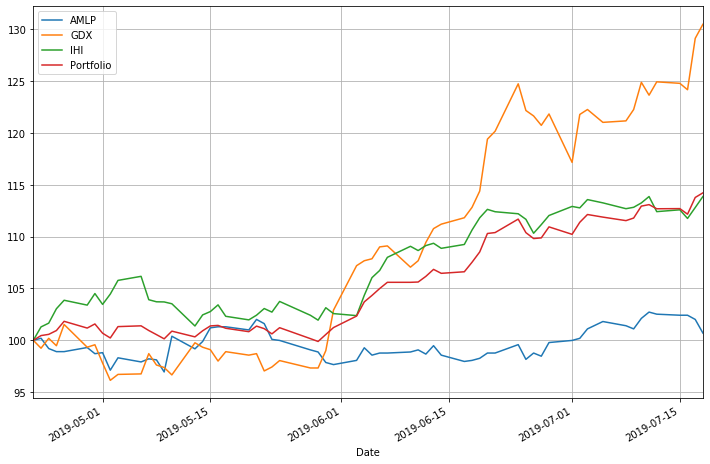

In [4]:
bounds = .16, .20
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(bounds=bounds)
quote.setup_mask(['IHI', 'AMLP', 'GDX'])
sd.update(quote.optimize_portfolio(bounds=bounds))
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(bounds=bounds))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)